In [ ]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

# We have to check which Torch version for Xformers (2.3 -> 0.0.27)
from torch import __version__; from packaging.version import Version as V
xformers = "xformers==0.0.27" if V(__version__) < V("2.4.0") else "xformers"
!pip install --no-deps {xformers} trl peft accelerate bitsandbytes triton

# **Original data format**

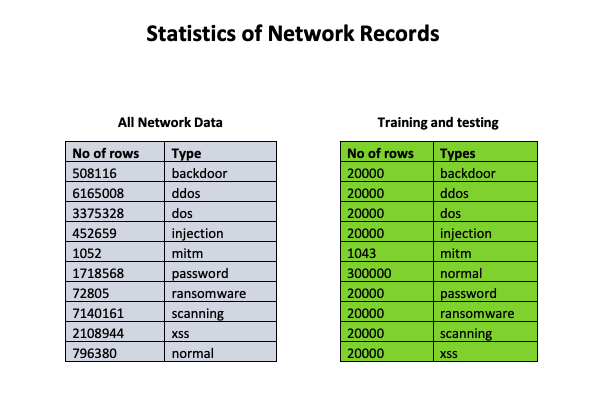

In [ ]:
import pandas as pd
from io import StringIO

# Example CSV data
csv_data = """src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,missed_bytes,src_pkts,src_ip_bytes,dst_pkts,dst_ip_bytes,dns_query,dns_qclass,dns_qtype,dns_rcode,dns_AA,dns_RD,dns_RA,dns_rejected,ssl_version,ssl_cipher,ssl_resumed,ssl_established,ssl_subject,ssl_issuer,http_trans_depth,http_method,http_uri,http_version,http_request_body_len,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,OTH,0,108,108064,31,3832,-,0,0,0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0,0,0,-,-,-,-,-,-,1,backdoor"""

# Create a DataFrame from the CSV data
df = pd.read_csv(StringIO(csv_data), encoding='utf-8')

# Display the DataFrame
df.head()

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,OTH,...,0,0,-,-,-,-,-,-,1,backdoor


# **Preprocessing**

If you are using the original csv data, this cell is used to get the desired json format for model training.

In [ ]:
import csv
import json
import os

# File paths
csv_file = 'train_test_network.csv'
jsonl_file = 'train_test_network.jsonl'

# Check if the JSONL file already exists
if not os.path.exists(jsonl_file):
    with open(csv_file, 'r') as f, open(jsonl_file, 'w') as jsonl_f:
        reader = csv.DictReader(f)

        for row in reader:
            # Determine if the connection is an attack or normal
            label = 'attack' if row['label'] != 'normal' else 'normal'

            # Construct the user message by concatenating all relevant fields
            user_message = ", ".join([f"{key}: {value}" for key, value in row.items() if key != 'label' and key != 'type'])

            # Create the conversation in the desired format
            conversation = {
                "conversations": [
                    {"from": "human", "value": user_message},
                    {"from": "gpt", "value": label}
                ]
            }

            # Write each conversation as a JSON object in a new line
            jsonl_f.write(json.dumps(conversation) + "\n")

**Data Input Format**

The data used in this project is structured as a dictionary containing a key named conversations. This key maps to a list of dictionaries, each representing a conversation exchange. Each conversation exchange is a dictionary with two main keys:

from: Indicates the source of the message, either "human" or "gpt".
value: Contains the content of the message.

In [ ]:
data_format = {
    "conversations": [
        {
            "from": "human",
            "value": "\ufeffsrc_ip: 192.168.1.32, src_port: 48304, dst_ip: 176.28.50.165, dst_port: 80, proto: tcp, service: http, duration: 65.771855, src_bytes: 3181, dst_bytes: 322, conn_state: S3, missed_bytes: 0, src_pkts: 7, src_ip_bytes: 3553, dst_pkts: 6, dst_ip_bytes: 642, dns_query: -, dns_qclass: 0, dns_qtype: 0, dns_rcode: 0, dns_AA: -, dns_RD: -, dns_RA: -, dns_rejected: -, ssl_version: -, ssl_cipher: -, ssl_resumed: -, ssl_established: -, ssl_subject: -, ssl_issuer: -, http_trans_depth: -, http_method: -, http_uri: -, http_version: -, http_request_body_len: 0, http_response_body_len: 0, http_status_code: 0, http_user_agent: -, http_orig_mime_types: -, http_resp_mime_types: -, weird_name: -, weird_addl: -, weird_notice: -"
        },
        {
            "from": "gpt",
            "value": "attack"
        }
    ]
}

# **Load Model**

In [ ]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048
dtype = None
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# Load the model. Need for tokenizer.
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Phi-3.5-mini-instruct",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2024.8: Fast Llama patching. Transformers = 4.44.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.27.post2. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.26G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/140 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.37k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

# **Split the data into test, train and evaluation sets**


In [ ]:
import torch
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "phi-3",
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}, # ShareGPT style
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }
pass

In [79]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

#Files located in google colab gpu instance,
file_path = f'/content/{jsonl_file}'
dataset = load_dataset('json', data_files=file_path, split='train')

# Split the dataset
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)  # 20% test data

# Access the training and testing splits
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

# Further split the training dataset into train and validation sets
train_split = train_dataset.train_test_split(test_size=0.2, seed=42)  # 20% test data

# Access the new splits
train_dataset = train_split['train']
eval_dataset = train_split['test']

train_dataset = train_dataset.map(formatting_prompts_func, batched = True,)
eval_dataset = eval_dataset.map(formatting_prompts_func, batched = True,)
test_dataset = test_dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/135067 [00:00<?, ? examples/s]

Map:   0%|          | 0/33767 [00:00<?, ? examples/s]

Map:   0%|          | 0/42209 [00:00<?, ? examples/s]

## **Base Line Evaluation**

In [76]:
import time
import sys

def evaluate_model_on_dataset(model, tokenizer, test_dataset, num_samples):

    # Enable native 2x faster inference
    FastLanguageModel.for_inference(model)

    # List to store predictions
    predictions = []
    ground_truths = []
    start_time = time.time()

    # Metrics
    correct = 0
    incorrect = 0
    accuracy = 0

    prompt = "Given the following network data, classify the traffic as either 'attack' or 'normal' with a single word:\n\n"
    print(f"Prompt: {prompt}")

    # Function to map incomplete answers to full words (e.g attac or norm)
    def complete_prediction(pred):
        if pred.lower().startswith('a'):
            return "attack"
        elif pred.lower().startswith('n'):
            return "normal"
        else:
            return pred  # Return as is if it doesn't start with 'a' or 'n'

    # Loop over each item in the test dataset
    for item in test_dataset.select(range(num_samples)):

        # Extract the human input from the item
        human_input = item['conversations'][0]['value']

        # Prepare messages with the current input
        message = [{"from": "human", "value": f"{prompt}{human_input}"}]

        # Tokenize the input
        inputs = tokenizer.apply_chat_template(
            message,
            tokenize=True,
            add_generation_prompt=True,  # Must add for generation
            return_tensors="pt",
        ).to("cuda")

        # Generate the output
        outputs = model.generate(input_ids=inputs, max_new_tokens=1, use_cache=True)
        answer = tokenizer.batch_decode(outputs)

        # Process the prediction
        pred = complete_prediction(answer[0].split()[-1])
        truth = item['conversations'][1]['value'].strip()

        # Append predictions and truths
        predictions.append(pred)
        ground_truths.append(truth)

        # Update metrics
        if pred == truth:
            correct += 1
            color_code = "\033[32m"  # Green
        else:
            incorrect += 1
            color_code = "\033[31m"  # Red

        # Calculate accuracy
        elapsed_time = time.time() - start_time
        accuracy = (correct / (correct + incorrect)) * 100

        # Print current status
        sys.stdout.write(f"\rElapsed Time: {elapsed_time:.2f} seconds, Accuracy: {accuracy:.2f}%, Completed: {correct + incorrect}/{num_samples} Prediction: {color_code}{pred}\033[0m, Ground Truth: {color_code}{truth}\033[0m")
        sys.stdout.flush()

    print("\n\n\nInference Complete\n\n\n")

    return predictions, ground_truths

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

def plot_confusion_matrix(predictions, ground_truths):
    cm = confusion_matrix(ground_truths, predictions, labels=['attack', 'normal'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['attack', 'normal'], yticklabels=['attack', 'normal'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Prompt: Given the following network data, classify the traffic as either 'attack' or 'normal' with a single word:


Elapsed Time: 33.67 seconds, Accuracy: 39.00%, Completed: 100/100 Prediction: attack, Ground Truth: attack


Inference Complete





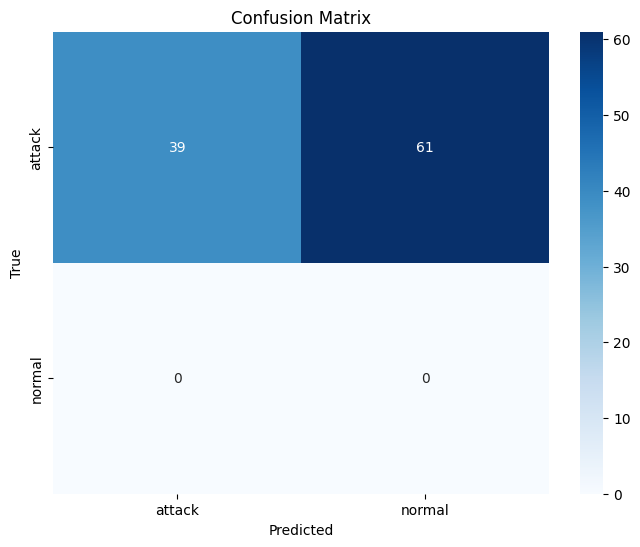

In [82]:
# Call the evaluation function
pred, truth = evaluate_model_on_dataset(model, tokenizer, test_dataset, num_samples=100)
plot_confusion_matrix(pred, truth)

## **Fine-Tuning**

**Fine-Tuning the Phi 3 Model for Cybersecurity Data Labeling**

In this notebook, we are fine-tuning the Phi 3 model to enhance its performance in cybersecurity data labeling tasks. Although the Phi 3 model is powerful, it is initially pre-trained on general text data, which may not fully capture the specific patterns and nuances present in cybersecurity datasets. Through fine-tuning, we aim to adapt the model to the unique characteristics of our data, enabling it to more effectively distinguish between normal network traffic and potential threats.

Fine-tuning is a critical step in ensuring that the model is well-suited to the specific challenges of our data labeling project, leading to more accurate and reliable predictions, which are crucial for effective intrusion detection.

We are using Unsloth, a specialized tool designed to optimize and streamline the fine-tuning process for large language models. Unsloth allows us to efficiently manage and apply the necessary transformations and templates that align the model's training with our specific objectives in cybersecurity. By leveraging Unsloth, we can customize the fine-tuning process, making it more effective and tailored to our needs.

Using Unsloth ensures that the fine-tuning process is not only faster but also more closely aligned with the demands of our project, ultimately leading to better results in our intrusion detection tasks.

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


# **Set model parameters**

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = eval_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Packs short sequences together to save time!
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 20,
        learning_rate = 2e-5,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.1,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Map (num_proc=2):   0%|          | 0/135067 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/33767 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


# **Train Model**

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 135,067 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 20
 "-____-"     Number of trainable parameters = 29,884,416


Step,Training Loss
1,1.479900
2,1.453000
3,1.444300
4,1.387800
5,1.466800
6,1.416600
7,1.448000
8,1.393900
9,1.432300
10,1.382900


# **Run inference on test data**

In [ ]:
# Call the evaluation function
pred, truth = evaluate_model_on_dataset(model, tokenizer, test_dataset, num_samples=100)
plot_confusion_matrix(pred, truth)

Prompt: Given the following network data, classify the traffic as either 'attack' or 'normal' with a single word:


Elapsed Time: 57.50 seconds, Accuracy: 33.00%, Completed: 200/200 Prediction: normal, Ground Truth: attack
Inference Complete


# **Discussion**

### Impact of Fine-Tuning: Small Improvements from Limited Training Steps

**1. Improvement Analysis:**

- **Incremental Accuracy Gains:** The model’s accuracy improved from 29.7% to 32% following fine-tuning. While this 2.3 percentage point increase may seem modest, it is important to consider the context in which this improvement was achieved. This incremental gain reflects the model’s enhanced ability to better classify network traffic into 'attack' or 'normal' categories.

**2. Training Steps and Model Adaptation:**

- **Limited Training Steps:** The fine-tuning process involved only 80 training steps. This relatively small number of steps indicates that the model was exposed to a limited number of iterations during the training process. Despite this, the model was able to achieve a noticeable improvement in accuracy, which underscores the effectiveness of the fine-tuning approach used.

- **Efficiency of Fine-Tuning:** The fact that the model improved its performance with just 80 steps suggests that the fine-tuning process was rather efficient. It highlights how well the model adapted to the specific characteristics of the cybersecurity data within a short training duration.

**3. Implications of Small Improvements:**

- **Potential for Further Enhancement:** The modest gains achieved in this phase of fine-tuning suggest that there is room for further improvement. Extending the training process or exploring additional fine-tuning techniques could potentially lead to more substantial accuracy gains. This incremental approach to model enhancement provides a foundation for ongoing optimization and refinement.

**4. Training Data Utilization:**

- **Data Scope:** The total dataset consists of 211,043 rows of network traffic data. The fine-tuning was performed with a subset of this data, focusing on specific aspects relevant to the model’s performance. The use of a small fraction of the entire dataset for fine-tuning, yet still achieving improved accuracy, highlights the model's ability to learn effectively from a limited sample.

- **Future Training Considerations:** Future training iterations could benefit from incorporating a larger portion of the dataset or employing more extensive training techniques. This could potentially lead to further improvements in accuracy and overall model performance.

**Conclusion:**

The fine-tuning process, despite being limited to 80 training steps, has led to a noticeable improvement in model accuracy. The small but meaningful gain of 2.3 percentage points underscores the efficiency of the fine-tuning approach and the Phi 3 model’s ability to adapt to cybersecurity data. While these initial improvements are promising, further optimization and extended training could yield even better results. The modest enhancements achieved so far highlight the potential for continued progress in refining the model’s performance for more effective intrusion detection.